This will the file I use to do scratch/one time use stuff.

In [1]:
from datasets import Dataset
import pandas as pd
import re
from dateutil import parser
from pathlib import Path
from string import punctuation
import math

/home/dck5549/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
#taken from 01_parse.ipynb

def check_trans(word_list, messages):
    all_words = {}
    counter = {} # includes actual words from conversation
    dict_counter = {} # includes words from dictionary
    
    for message in messages:
        content = message.split(" ")
        for word in content:
            word = word.strip(punctuation).lower()
            if len(word)>1:
                if word in all_words:
                    all_words[word] += 1
                elif word.isalpha() == True:
                    all_words[word] = 1
                else:
                    if word[0].isnumeric() == False:
                        for symbol in punctuation:
                            if symbol in word:
                                split_word = word.split(symbol)
                                for section in split_word:
                                    if len(section) > 1:
                                        if word in all_words:
                                            all_words[word] += 1
                                        else:
                                            if word.isalpha() == True:
                                                all_words[word] = 1
                for check in word_list:
                    find = re.match(check, word)
                    if find != None:
                        if check[-1] != "*":
                            if len(word) > find.span()[1]:
                                continue
                        else:
                            if len(word) < len(check):
                                continue
                        if word not in counter:
                            counter[word] = 1
                        else:
                            counter[word] += 1
                        if check not in dict_counter:
                            dict_counter[check] = 1
                        else:
                            dict_counter[check] += 1
    return counter, dict_counter, all_words

In [2]:
#taken from 01_parse.ipynb
# Helper functions to parse transcripts, adapted from megan's code
# Input: path to directory full of transcripts
# Output: a DataFrame of all the utterances in the transcript and their speaker
def parse_trans(path):

   tran_path = Path(path)
   tran_list = list(tran_path.glob('*.txt'))
   transcripts = {}
   time = 0
   for filepath in tran_list:
      name = Path(filepath).stem
      with open(filepath,'r',encoding='utf-8') as my_file:
         data = my_file.readlines()
         clean = []
         for line in data:
            if ":" in line and line[:1].isnumeric() == False:
               clean.append(line.strip() + "&&" +  str(time))
            elif ":" in line and line[:1].isnumeric() == True:
               time +=1
      transcripts[name] = clean


   last_time = 0
   trans_df = pd.DataFrame()
   for session in transcripts:
      s_df = pd.DataFrame.from_dict(transcripts[session])
      def trans_proccess(c): 

         global g_time
         x=c[0].strip()
         # print(x)
         try:
            speaker = re.search(r"^[^:]*:\s*", x).group()[:-2]
         except:
            speaker = ""
         try:
            content = re.search(r":(.*)&&", x).group()[1:-2]
         except:
            content = ""
         try:
            time = int(re.search(r"&&.*", x).group()[2:])
            g_time = time
         except:
            time = -1

         if(speaker == "" and content == ""):
            speaker = None
            content = None

         row = pd.Series(dtype='float64')

         row['speaker'] = speaker
         row['content'] = content
         row['block'] = time-last_time 
         row['session'] = session
         return row
      trans_df = pd.concat([trans_df, s_df.apply(lambda x: trans_proccess(x), axis=1)])
      last_time = g_time
   trans_df = trans_df.dropna()
   trans_df = trans_df[trans_df['block'] >= 0].reset_index(drop=True)
   trans_df['block'] = (trans_df['block'] / trans_df['block'].max() * num_blocks).apply(math.floor)
   trans_df['session'] = trans_df['session'].astype('int')
   return trans_df

In [11]:
#Parsing NEK21_MAG/13.txt so it can be hand labeled
folder = "temp_folder"
num_blocks = 3
mag_13 = parse_trans(folder)

In [12]:
content = mag_13['content']

In [13]:
# Save Data
mag_13.to_csv("temp_folder/NEK21_MAG13.csv")

Below I do some testing of the already trained models. Code is from 02_classify

In [3]:
# %%
from datasets import Dataset
import pandas as pd
from transformers import BertForSequenceClassification, AutoTokenizer
import numpy as np


In [4]:
# %%
#load model
model = BertForSequenceClassification.from_pretrained("../models/model_mrda_v2_t1.model")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

labels = ["statement", "disruption", "backchannel", "follow-me", "question"]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}


In [5]:

# Preproccesses data before classifcation
def preproccess(samples):
    encoding = tokenizer.encode_plus(samples['content'], add_special_tokens = True,
                        max_length = 32,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True,
                        padding="max_length")
  
    samples['input_ids'] = encoding['input_ids']
    samples['token_type_ids'] = encoding['token_type_ids']
    samples['attention_mask'] = encoding['attention_mask']
    return samples


# %%
# Uses trained model to classify
def classify(samples):
    out = model(samples['input_ids'], token_type_ids=samples['token_type_ids'], attention_mask=samples['attention_mask'])
    logits = out.logits.detach().cpu().numpy()

    samples['logits'] = logits[0]
    samples['labels_h'] = labels[logits.argmax()]
    samples['labels'] = logits.argmax()
    return samples


In [6]:
#Load in chat & transcript data
NEK21_df = pd.read_csv('temp_folder/NEK21_MAG13.csv')
NEK21_df = NEK21_df.dropna()

NEK21 = Dataset.from_pandas(NEK21_df)



NEK21 = NEK21.map(preproccess)
NEK21.set_format('torch')
NEK21 = NEK21.map(classify)

NEK21.to_csv('temp_folder/NEK21_13_results.csv')


Map:   0%|          | 0/625 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [6]:
#load in results from ^, and the hand-labeled results 
labels = ["s", "d", "b", "f", "q"]
label2id = {label:idx for idx, label in enumerate(labels)}

preds = pd.read_csv("temp_folder/NEK21_13_results.csv")
hand_labled = pd.read_csv("fewshot_labels/NEK21_MAG13.csv")

In [7]:
from sklearn.preprocessing import OneHotEncoder

# preproccess BERT machine labeled labels by putting them into one-hot format
onehot_enc = OneHotEncoder(sparse=False)
bert_labels_raw = preds['labels'][0:].to_numpy().reshape(preds['labels'].size,1)
bert_labels = onehot_enc.fit_transform(bert_labels_raw)

/home/dck5549/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:

# transform hand labels to one-hot format
h1_raw = hand_labled
h1_raw = h1_raw.replace({'labels_h': label2id})['labels_h'].to_numpy().reshape([-1,1])
h1_labels = onehot_enc.fit_transform(h1_raw)

/home/dck5549/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
h1_raw

array([[0],
       [0],
       [0],
       [0],
       [4],
       [2],
       [4],
       [4],
       [0],
       [4],
       [0],
       [0],
       [4],
       [0],
       [2],
       [2],
       [4],
       [0],
       [0],
       [0],
       [4],
       [0],
       [1],
       [0],
       [0],
       [4],
       [0],
       [0],
       [0],
       [4],
       [2],
       [4],
       [0],
       [2],
       [0],
       [0],
       [0],
       [4],
       [0],
       [2],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [4],
       [0],
       [0],
       [2],
       [0],
       [2],
       [4],
       [0],
       [0],
       [0],
       [4],
       [2],
       [0],
       [1],
       [1],
       [0],
       [4],
       [1],
       [0],
       [4],
       [0],
       [0],
       [0],
       [2],
       [4],
       [0],
       [0],
       [4],
       [0],
       [2],
       [0],
       [0],
       [4],
    

In [10]:
#model never predicts disruption?? This is also true in the 03_bert_validation
h,hc = np.unique(h1_raw, return_counts=True)
b,bc = np.unique(bert_labels_raw, return_counts=True)

print("Distribution of Hand Labels:")
for i, val in enumerate(h):
    print(f'{labels[val]}: {hc[i]}')

print("Distribution of Model Labels:")
for i, val in enumerate(b):
    print(f'{labels[val]}: {bc[i]}')


Distribution of Hand Labels:
s: 354
d: 75
b: 50
f: 4
q: 142
Distribution of Model Labels:
s: 451
b: 12
f: 2
q: 160


In [11]:
correct = 0
s_correct = 0
q_correct = 0
d_correct = 0
b_correct = 0
f_correct = 0


for i,l in enumerate(h1_raw):

    if l[0] == bert_labels_raw[i][0]:
        correct += 1

        t = labels[l[0]]
        if t == "s":
            s_correct += 1
        elif t == "q":
            q_correct += 1
        elif t == "d":
            d_correct += 1
        elif t == "f":
            f_correct += 1
        else:
            b_correct += 1
        

print(f'Total Accuracy: {correct/len(h1_raw)}%')
print(f'Statement Accuracy: {s_correct/hc[0]}%')
print(f'Disruption Accuracy: {d_correct/hc[1]}%')
print(f'Backchannel Accuracy: {b_correct/hc[2]}%')
print(f'Follow-me Accuracy: {f_correct/hc[3]}%')
print(f'Question Accuracy: {q_correct/hc[4]}%')

Total Accuracy: 0.7648%
Statement Accuracy: 0.943502824858757%
Disruption Accuracy: 0.0%
Backchannel Accuracy: 0.12%
Follow-me Accuracy: 0.0%
Question Accuracy: 0.971830985915493%


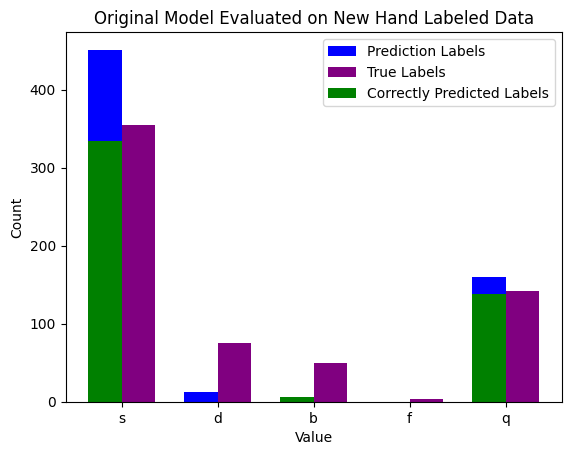

In [12]:
import matplotlib.pyplot as plt

true_hist = hc.tolist()
pred_hist = bc.tolist()
pred_hist.insert(3,0)

correct = [s_correct, d_correct, b_correct, f_correct, q_correct]

plot_labels = ['s', 'd', 'b', 'f', 'q']

x = np.arange(5)
bar_width = 0.35

plt.bar(x - bar_width/2, pred_hist, bar_width, label='Prediction Labels', color='blue')

# Create the second set of bars next to the first set
plt.bar(x + bar_width/2, true_hist, bar_width, label='True Labels', color='purple')

plt.bar(x - bar_width/2, correct, bar_width, label='Correctly Predicted Labels', color='green', alpha=1)

plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(x, plot_labels)
plt.legend()

plt.title('Original Model Evaluated on New Hand Labeled Data')

plt.show()

In [13]:
# Define a mapping function
def map_values(value):
    return id2label.get(value, value)

# Use numpy.vectorize to apply the mapping function to the entire array
hand = list(np.vectorize(map_values)(h1_raw).ravel())
bert = list(np.vectorize(map_values)(bert_labels_raw).ravel())


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


labels = ["statement", "disruption", "backchannel", "follow-me", "question"]

# Example lists of true labels and model predictions
true_labels = pd.DataFrame(hand)[0]
model_predictions = pd.DataFrame(bert)[0]

# Convert string labels to numerical labels if needed (depends on the specific metrics you want to compute)
# For example, if using precision, recall, and F1-score, numerical labels are required
label_mapping = {label: idx for idx, label in enumerate(true_labels.unique())}
true_labels_numeric = true_labels.map(label_mapping)
model_predictions_numeric = model_predictions.map(label_mapping)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, model_predictions)
precision = precision_score(true_labels_numeric, model_predictions_numeric, average='weighted')
recall = recall_score(true_labels_numeric, model_predictions_numeric, average='weighted')
f1 = f1_score(true_labels_numeric, model_predictions_numeric, average='weighted')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, model_predictions))

# Compute and display confusion matrix with columns
conf_matrix = confusion_matrix(true_labels, model_predictions, labels=true_labels.unique())
conf_matrix_df = pd.DataFrame(conf_matrix, index=true_labels.unique(), columns=true_labels.unique())
print("\nConfusion Matrix:")
print(conf_matrix_df)

# Calculate accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracies_df = pd.DataFrame({'Accuracy': class_accuracies}, index=true_labels.unique())
print("\nAccuracy for Each Class:")
print(class_accuracies_df)

Accuracy: 0.7648
Precision: 0.6554
Recall: 0.7648
F1-score: 0.6931

Classification Report:
              precision    recall  f1-score   support

 backchannel       0.50      0.12      0.19        50
  disruption       0.00      0.00      0.00        75
   follow-me       0.00      0.00      0.00         4
    question       0.86      0.97      0.91       142
   statement       0.74      0.94      0.83       354

    accuracy                           0.76       625
   macro avg       0.42      0.41      0.39       625
weighted avg       0.66      0.76      0.69       625


Confusion Matrix:
             statement  question  backchannel  disruption  follow-me
statement          334        14            6           0          0
question             4       138            0           0          0
backchannel         43         1            6           0          0
disruption          70         3            0           0          2
follow-me            0         4            0           

/home/dck5549/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dck5549/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dck5549/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dck5549/.local/lib/python3.10/site-packag

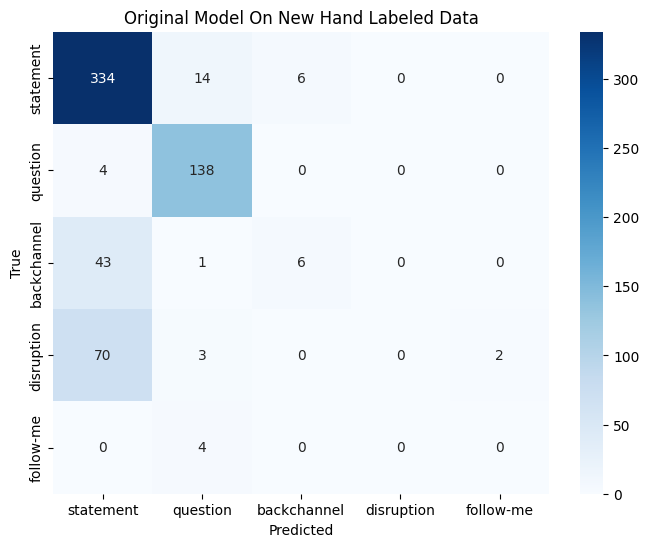

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns






# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=true_labels.unique(), yticklabels=true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Original Model On New Hand Labeled Data')
plt.show()

In [3]:
mrda = pd.read_csv('gpt_classification/results/mrda_results_and_true.csv')
trans16 = pd.read_csv('gpt_classification/results/results_and_trans16.csv')
mrda

,Unnamed: 0,preds,explanations,true,utterance
0,0,f,"The utterance ""okay."" is classified as a Floor...",f,okay.
1,1,f,"The utterance ""so um"" is classified as a Floor...",f,so um
2,2,s,"The utterance ""i was going to try to get out o...",s,i was going to try to get out of here like in ...
3,3,f,"The utterance ""um"" is classified as a Floor Gr...",f,um
4,4,s,"The utterance ""because i really appreciate peo...",s,because i really appreciate people coming.
...,...,...,...,...,...
495,495,s,"The utterance ""as easy it could as it could be...",s,as easy it could as it could be.
496,496,f,"The utterance ""but"" is classified as a Floor G...",f,but
497,497,s,"The utterance ""i suppose that as long as they ...",d,i suppose that as long as they have a type her...
498,498,f,"The utterance ""um"" is classified as a Floor Gr...",f,um


In [14]:
mrda_wrong = mrda[mrda['preds'] != mrda['true']]

for i, row in mrda_wrong.iterrows():
    print(f'Utterance: {row[4]}')
    print(f'Model Pred: {row[1]}')
    print(f'True Pred: {row[3]}')
    print(f'Explanation: {row[2]}')
    print('\n')

Utterance: so we have this um
Model Pred: f
True Pred: d
Explanation: This utterance is classified as a floor grabber (<f>) because it is a filler word ("um") used by the speaker to interrupt and gain attention. 


Utterance: i mean i had a web page up.
Model Pred: f
True Pred: s
Explanation: The utterance "i mean i had a web page up." is a floor grabber because it starts with the floor grabber phrase "i mean" which is commonly used to interrupt and gain attention. 


Utterance: right.
Model Pred: b
True Pred: s
Explanation: The utterance "right." is a backchannel because it is a short utterance that indicates agreement or understanding without directly addressing anyone.


Utterance: i actually mostly need to be able to link up or
Model Pred: s
True Pred: d
Explanation: The utterance "i actually mostly need to be able to link up or" is classified as a Statement because it is a complete sentence expressing a need or requirement. 


Utterance: it's it's a question both of what the repre

In [15]:
trans16_wrong = trans16[trans16['preds'] != trans16['true']]

for i, row in trans16_wrong.iterrows():
    print(f'Utterance: {row[4]}')
    print(f'Model Pred: {row[1]}')
    print(f'True Pred: {row[3]}')
    print(f'Explanation: {row[2]}')
    print('\n')

Utterance: Nothing [UI]
Model Pred: d
True Pred: s
Explanation: The third utterance "Nothing [UI]" is marked as incomplete (<d>) because it contains an unintelligible portion indicated by "[UI]". 


Utterance: Oh, I started already. Phew! In my isolation?
Model Pred: s
True Pred: q
Explanation: The first utterance is classified as a statement (<s>) because it is a complete sentence expressing the speaker's thoughts and feelings. 


Utterance: Cool. Everything? Everyone?
Model Pred: s
True Pred: q
Explanation: The fourth utterance is classified as a statement (<s>) because it is a complete sentence expressing the speaker's opinion. 


Utterance: Cool.
Model Pred: s
True Pred: b
Explanation: Failed to retrieve


Utterance: Alright.
Model Pred: s
True Pred: f
Explanation: Failed to retrieve


Utterance: Compote…Com-pote! Com-pote!
Model Pred: d
True Pred: s
Explanation: The fifth utterance "Compote…Com-pote! Com-pote!" is an incomplete utterance as it is interrupted by the repetition of "